In [3]:
import msprime, tskit, time
import numpy as np
from IPython.display import SVG
import matplotlib.pyplot as plt
from algorithm._metric_ import (node_tree_discrepancy, discrepancy)

### The Truth
The following will be our final images, and data collection for how the `extend_edges` method compares to other methods/packages including `tsinfer` and `keep_unary`.

We first will generate a tree sequence which will serve as our 'ground truth'. 
Then using `simplify` we can then simplify this tree sequence using `TSkit` and then we extend the simplified tree sequence and compare.

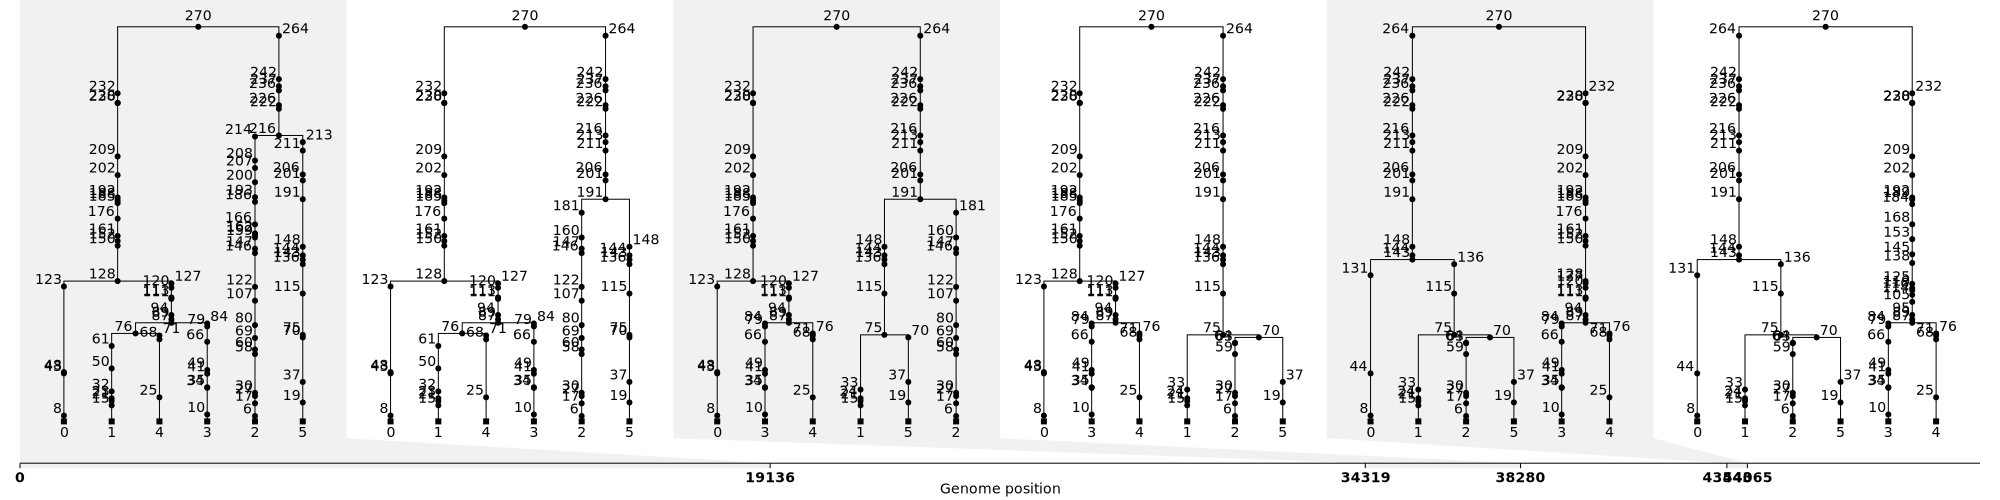

In [4]:
ts = msprime.sim_ancestry(3, population_size=1000, sequence_length=1e6, recombination_rate=1e-8,
                         record_full_arg=True)
SVG(ts.draw_svg(size=(2000, 500), x_lim=[0, 5e4]))

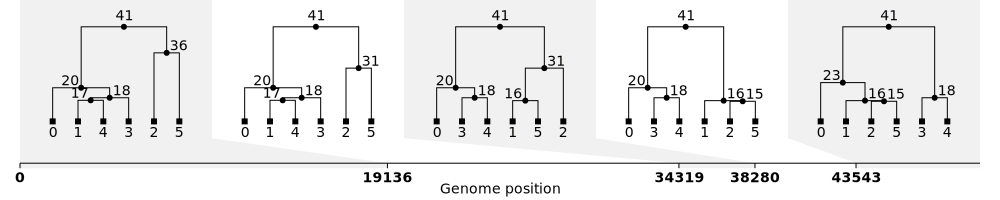

In [5]:
sts = ts.simplify()
# uts = ts.simplify(keep_unary=True)
SVG(sts.draw_svg(x_lim=[0, 5e4]))

Currently, we still have `extend_edges` output a bunch of print statements. We should fix that so it stops.

In [6]:
ets = sts.extend_edges()

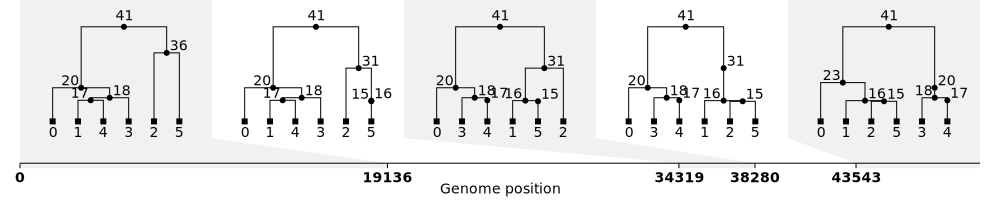

In [7]:
SVG(ets.draw_svg(x_lim=[0, 5e4]))

Note that `keep_unary_if_coalescence` is not a parameter anymore. 

There is now `keep_unary` which outputs the same tree sequence as the original (not helpful).

There is also `keep_unary_in_individuals` which has the same number of edges as simplified.

In [10]:
print("Number of edges:")
print(f'   original: {ts.num_edges}')
print(f" simplified: {sts.num_edges}")
# print(f" keep unary: {uts.num_edges}")
print(f"   extended: {ets.num_edges}")

Number of edges:
   original: 919
 simplified: 219
   extended: 163


### Lets see how many edges are reduced with 3 samples over 100 replicate tree sequences of genome length $10^6$

In [15]:
res = []
for ts in msprime.sim_ancestry(3, population_size=1000, sequence_length=1e6, recombination_rate=1e-8, random_seed=40,
                          record_full_arg=True, num_replicates=100):
    sts = ts.simplify()
    #new_sts = ts.simplify(keep_unary_if_coalescent=True)
    ets = sts.extend_edges()
    res.append((sts.num_edges, ets.num_edges))

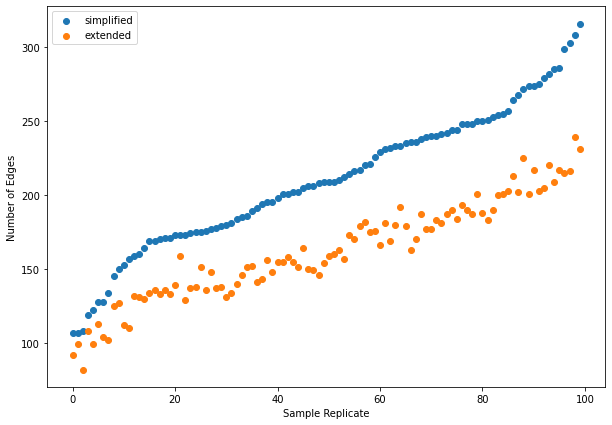

In [21]:
res = np.array(res)
x = np.argsort(np.argsort(res[:, 0]))

fig, ax = plt.subplots(figsize=(10,7))

ax.scatter(x, res[:, 0], label='simplified')
ax.scatter(x, res[:, 1], label='extended')
ax.set_xlabel('Sample Replicate')
ax.set_ylabel("Number of Edges")
ax.set_title('')
ax.legend();
plt.savefig('paper/simplified_vs_extended_100reps_SL1e6.png')


## Now lets extend our analysis to a sample size of 1000.

In [22]:
res = []
for ts in msprime.sim_ancestry(1000, population_size=1000, sequence_length=1e6, recombination_rate=1e-8, random_seed=40,
                          record_full_arg=True, num_replicates=100):
    sts = ts.simplify()
    #new_sts = ts.simplify(keep_unary_if_coalescent=True)
    ets = sts.extend_edges()
    res.append((sts.num_edges, ets.num_edges))

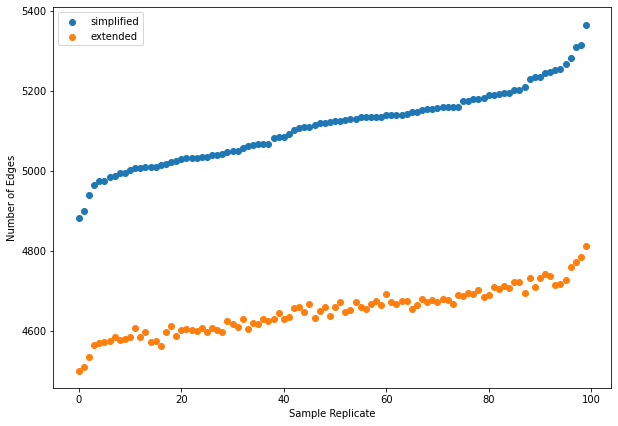

In [23]:
res = np.array(res)
x = np.argsort(np.argsort(res[:, 0]))

fig, ax = plt.subplots(figsize=(10,7))

ax.scatter(x, res[:, 0], label='simplified')
ax.scatter(x, res[:, 1], label='extended')
ax.set_xlabel('Sample Replicate')
ax.set_ylabel("Number of Edges")
ax.set_title('')
ax.legend();
plt.savefig('paper/simplified_vs_extended_1000sample_100reps_SL1e6.png')

### Now lets increase the genome length to $10^7$
We will decrease number of replicates to save time.

In [38]:
res = []
for ts in msprime.sim_ancestry(1000, population_size=1000, sequence_length=1e7, recombination_rate=1e-8, random_seed=40,
                          record_full_arg=True, num_replicates=50):
    sts = ts.simplify()
    #new_sts = ts.simplify(keep_unary_if_coalescent=True)
    ets = sts.extend_edges()
    print('extended!')
    res.append((sts.num_edges, ets.num_edges))

extended!
extended!
extended!
extended!
extended!
extended!
extended!
extended!
extended!
extended!
extended!
extended!
extended!
extended!
extended!
extended!
extended!
extended!
extended!
extended!
extended!
extended!
extended!
extended!
extended!
extended!
extended!
extended!
extended!
extended!
extended!
extended!
extended!
extended!
extended!
extended!
extended!
extended!
extended!
extended!
extended!
extended!
extended!
extended!
extended!
extended!
extended!
extended!
extended!
extended!


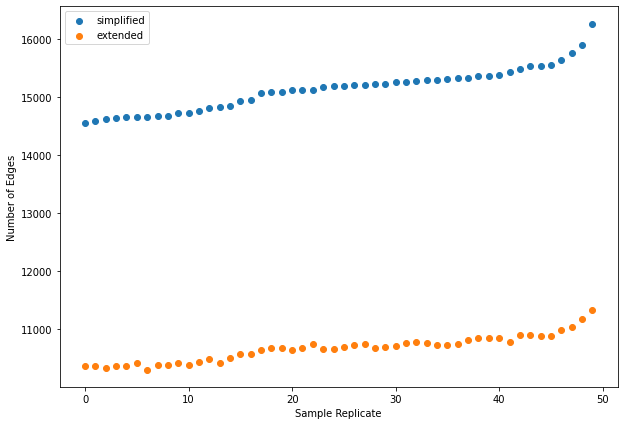

In [39]:
res = np.array(res)
x = np.argsort(np.argsort(res[:, 0]))

fig, ax = plt.subplots(figsize=(10,7))

ax.scatter(x, res[:, 0], label='simplified')
ax.scatter(x, res[:, 1], label='extended')
ax.set_xlabel('Sample Replicate')
ax.set_ylabel("Number of Edges")
ax.set_title('')
ax.legend();
plt.savefig('paper/simplified_vs_extended_1000sample_50reps_SL1e7.png')

In [47]:
props = np.asarray([1-(res[i,1]/res[i,0]) for i in range(res.shape[0])])
print('For sequence length 10^7, the edge_extend method reduces the number of edges of a simplified tree sequence by', np.average(props), 'on average.')

For sequence length 10^7, the edge_extend method reduces the number of edges of a simplified tree sequence by 0.2956345753417122 on average.


### Compare ratio of edges to sequence length between simplified and extended tree sequences.

In [11]:
res = {}
for num_samples in [10, 100, 1000]:
    res[num_samples] = {}
    for L in [1e6, 3e6, 6e6, 9e6]:
        ts = msprime.sim_ancestry(num_samples, population_size=1000, sequence_length=L,
                                  recombination_rate=1e-8, record_full_arg=True)
        sts = ts.simplify()
        ext_sts = sts.extend_edges()
        res[num_samples][L] = (sts.num_edges, ext_sts.num_edges)

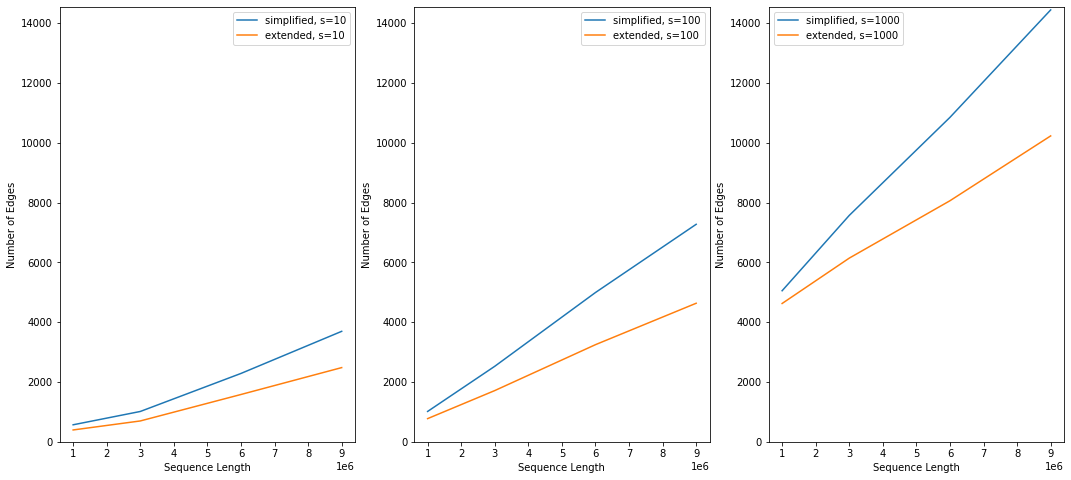

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(18, 8))

maxval = 0
for a in res.values():
    for b in a.values():
        maxval = max(maxval, max(b))

for ax, num_samples in zip(axes, res):
    Lvals = list(res[num_samples].keys())
    Lvals.sort()
    sim = [res[num_samples][L][0] for L in Lvals]
    ext = [res[num_samples][L][1] for L in Lvals]
    ax.plot(Lvals, sim, label=f"simplified, s={num_samples}")
    ax.plot(Lvals, ext, label=f"extended, s={num_samples}")
    ax.set_xlabel("Sequence Length")
    ax.set_ylabel("Number of Edges")
    ax.set_ylim(0, maxval+100)
    ax.legend();
    plt.savefig('paper/SL_vs_NumEdges.png')

## Visualize the Proportions of Edges reduced between simplified and extended sequences.

In [26]:
props = {}
for num_samples in res:
    props[num_samples] = {}
    for L in res[num_samples].keys():
        props[num_samples][L] = (1-(res[num_samples][L][1]/res[num_samples][L][0]))

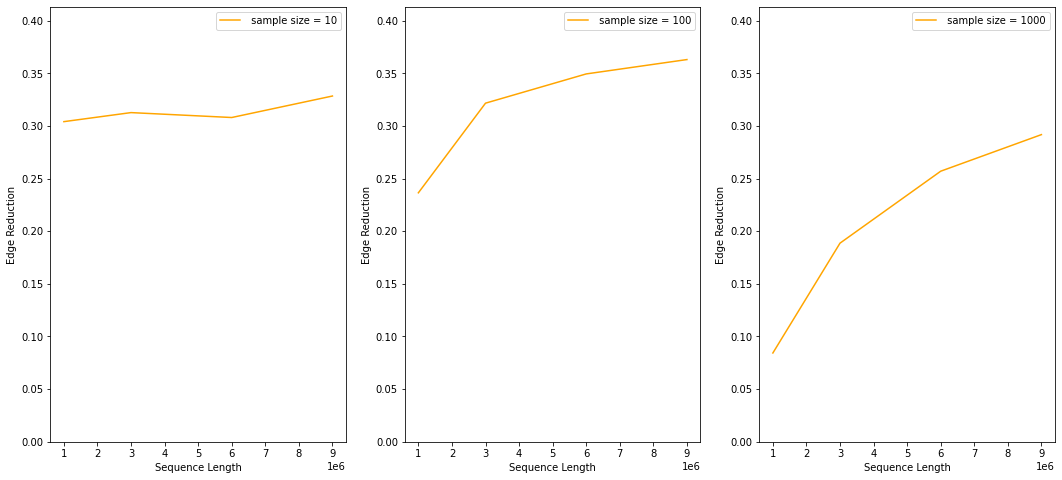

In [37]:
fig, axes = plt.subplots(1, 3, figsize = (18,8))

maxval = 0
for a in props.values():
    for b in a.values():
        maxval = max(maxval, b)

for ax, num_samples in zip(axes, res):
    Lvals = list(props[num_samples].keys())
    Lvals.sort()
    sim = [props[num_samples][L] for L in Lvals]
    ax.plot(Lvals, sim, label=f" sample size = {num_samples}", color = 'orange')
    ax.set_xlabel("Sequence Length")
    ax.set_ylabel("Edge Reduction")
    ax.set_ylim(0, maxval+0.05)
    ax.legend();
    plt.savefig('paper/SL_vs_EdgeReduction.png')

### Edge Inference
We know look at proportion of edges which were correctly inserted into neighboring trees with `edge_extend`.

In [39]:
def get_span_stats(ts, ets):
    time_map = {}
    for n in ts.nodes():
        time_map[n.time] = n.id
    total_added_span = 0
    wrongly_added_span = 0
    for interval, t, et in ts.coiterate(ets):
        interval_length = interval[1] - interval[0]
        t_nodes = list(t.nodes())
        for n in et.nodes():
            if et.num_children(n) == 1:
                total_added_span += interval_length
            on = time_map[et.time(n)]
            if on not in t_nodes:
                assert et.num_children(n) == 1
                wrongly_added_span += interval_length
    return total_added_span, wrongly_added_span

In [40]:
total_added_span, wrongly_added_span = get_span_stats(ts, ets)
print(f"Out of a total of {total_added_span} added edge span, "
      f"we have wrongly added {wrongly_added_span} span, "
      f"a proportion of {wrongly_added_span / total_added_span}.")

Out of a total of 3037044.0 added edge span, we have wrongly added 2418.0 span, a proportion of 0.0007961689063444587.


# What's the sampling distribution?

In [61]:
reps = msprime.sim_ancestry(20, population_size=1000, sequence_length=1e6, recombination_rate=1e-8,
                           record_full_arg=True, num_replicates=100)
totals = []
wrongs = []
for ts in reps:
    ets = (ts.simplify()).extend_edges()
    a, b = get_span_stats(ts, ets)
    totals.append(a)
    wrongs.append(b)

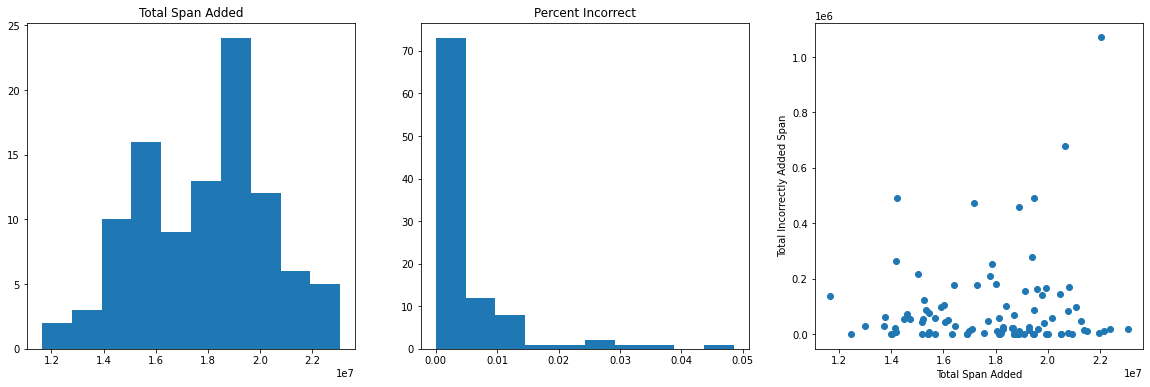

In [62]:
totals = np.array(totals)
wrongs = np.array(wrongs)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,6))
ax1.hist(totals)
ax1.set_title("Total Span Added")
ax2.hist(wrongs/totals)
ax2.set_title("Percent Incorrect")
ax3.scatter(totals, wrongs)
ax3.set_xlabel("Total Span Added")
ax3.set_ylabel("Total Incorrectly Added Span")
plt.savefig('paper/sampling_distribution_recomb')

# Other ideas

- Make a plot with x-axis along the genome and y-axis time
with a line for each added edge
and color whether it was right or not.

# What's about gene conversion events?

Here's the same thing, but with gene conversion instead of recombination:

In [63]:
reps = msprime.sim_ancestry(20, population_size=1000, sequence_length=1e6, 
                            gene_conversion_rate=1e-8, gene_conversion_tract_length=1000,
                            record_full_arg=True, num_replicates=100)
totals = []
wrongs = []
for ts in reps:
    ets = (ts.simplify()).extend_edges()
    a, b = get_span_stats(ts, ets)
    totals.append(a)
    wrongs.append(b)

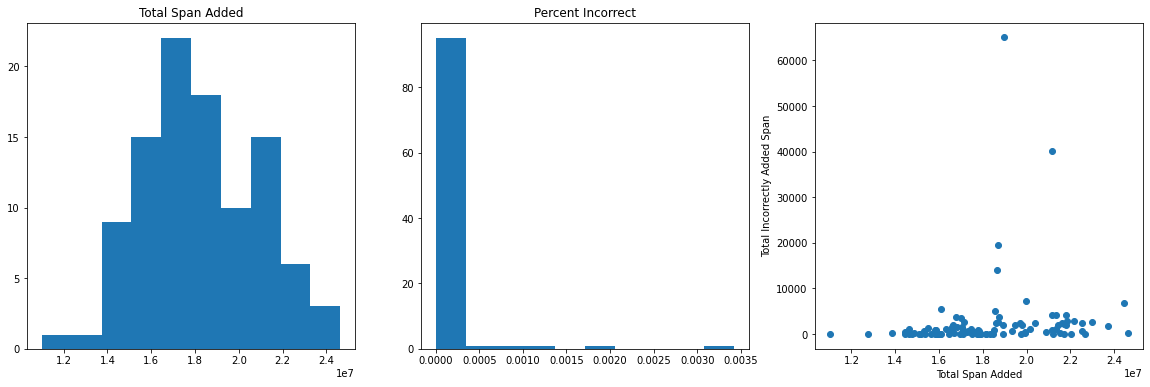

In [64]:
totals = np.array(totals)
wrongs = np.array(wrongs)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,6))
ax1.hist(totals)
ax1.set_title("Total Span Added")
ax2.hist(wrongs/totals)
ax2.set_title("Percent Incorrect")
ax3.scatter(totals, wrongs)
ax3.set_xlabel("Total Span Added")
ax3.set_ylabel("Total Incorrectly Added Span");
plt.savefig('paper/sampling_distribution_geneconversion')

# Computing Statsitcs
We also want to look at computation time on simplified and extended tree sequences when computing statistics like TajimasD.

In [16]:
samples = [200,400]
lengths = [1e6, 5e6, 1e7, 5e7, 1e8]
stimes = np.zeros((len(samples),len(lengths)))
etimes = np.zeros((len(samples),len(lengths)))
for i,s in enumerate(samples):
    for j,l in enumerate(lengths):
        ts = msprime.sim_ancestry(s,population_size=1000, sequence_length=l, record_full_arg=True)
        sts = ts.simplify()
        start = time.time()
        sts.Tajimas_D()
        end = time.time()
        stimes[i,j] = end-start
        #print('SIMPLIFIED', s, l, '\n Time:', end-start)
        
        ets = sts.extend_edges()
        start = time.time()
        ets.Tajimas_D()
        end = time.time()
        etimes[i,j] = end-start
        #print('EXTENDED', s, l, '\n Time:', end-start)

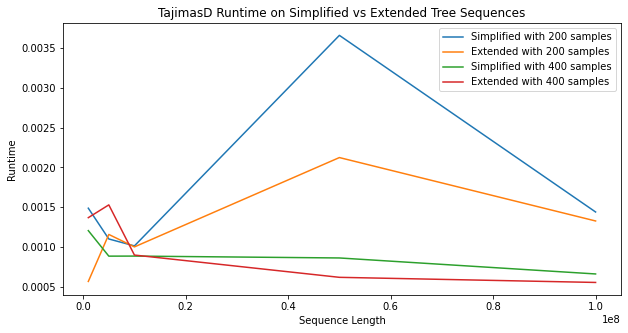

In [17]:
sl_fig, slax = plt.subplots(figsize = (10,5))
for i in range(len(samples)):
    slax.plot(lengths, stimes[i,:], label=f'Simplified with {samples[i]} samples')
    slax.plot(lengths, etimes[i,:], label=f'Extended with {samples[i]} samples')
    slax.set_xlabel('Sequence Length')
    slax.set_ylabel('Runtime')
    slax.legend()
    slax.set_title('TajimasD Runtime on Simplified vs Extended Tree Sequences')    
    plt.savefig('paper/discrepancy_runtime.png')

# Discrepancy Function

For a tree sequence $T$ and a node $x$ and position $i$, let $D_T(x, i)$ be the set of descendant
samples of $x$ in $T$ at position $i$, and for node $x$ in $T_1$ and node $y$ in $T_2$, where both $T_j$
are tree sequences of length $L$, let
$$
   \rho_{T_1, T_2}(x, y)
   =
   \frac{1}{L} \sum_i \left[ D_{T_1}(x, i) == D_{T_2}(y, i) \right],
$$
where the thing in the $[ ]$'s means that it should be 1 if True, 0 if False.
This is the fraction of the sequence along which $x$ and $y$ have exactly the same descendant set
(and so is a similiarity).
Then, let
$$
  \widehat{d}(x, T_1, T_2) = \min_y \left\{ |t_x-t_y|(1 - \rho_{T_1, T_2}(x, y)) \right\} ,
$$
which is the proportion of the genome over which the descendant set of $x$ *does not* match
that of $y$, where $y$ is it's (global) best matching node. This proportion is weighted by the difference of the branch lengths $|t_x-t_y|$, where $t_x$ and $t_y$ denote the time of occurance for nodes $x$ and $y$, respectively. 

Note that this is *different* than
$$
   \frac{1}{L} \sum_i \min_y \left(1 - \left[ D_{T_1}(x, i) == D_{T_2}(y, i) \right]\right),
$$
which would tell us the proportion of the genome over which $x$ does not have a perfectly matching node,
i.e., a node which has exactly the same descendant set.

We are doing this because want to find the node $y$ that is the best match over the whole genome,
since this tells us how well nodes are identified across trees.

We then define the *discrepancy* between $T_1$ and $T_2$ to be 
$$
\widehat{d}(T_1,T_2) = \sum_{x\in T_1} \widehat{d}(x, T_1, T_2) .
$$

Note that the algorithm to compute this
is $n_1 t$, rather than $n_1 n_2 t$ as we had above,
because on each tree, for each node $x$,
we need only look at $O(1)$ nodes rather than all nodes.

### Test runtime of Discrepancy function

In [18]:
samples = [5,9]
lengthlist = [1e5, 5e5, 1e6, 5e6, 1e7, 5e7]
ltimes = np.zeros((len(samples),len(lengthlist)))

for i, num_samples in enumerate(samples):
    for j, L in enumerate(lengthlist):
        ts = msprime.sim_ancestry(num_samples, population_size=1000, sequence_length=L,
                                  recombination_rate=1e-8, record_full_arg=True)
        sts = ts.simplify()
        
        ext_sts= sts.extend_edges()
        start_time = time.time()
        d = discrepancy(ext_sts, ts)
        print(f'number of samples = {num_samples}, length = {L}\n original discrepancy number = {d}')
        print(f'Discrepancy / Length = {d/L}')
        end_time = time.time()
        ltimes[i,j] = end_time - start_time
        print('time to compute: ', ltimes[i,j])

number of samples = 5, length = 100000.0
 original discrepancy number = 593926.0
Discrepancy / Length = 5.93926
time to compute:  0.018976926803588867
number of samples = 5, length = 500000.0
 original discrepancy number = 15084965.0
Discrepancy / Length = 30.16993
time to compute:  0.15730977058410645
number of samples = 5, length = 1000000.0
 original discrepancy number = 40705778.0
Discrepancy / Length = 40.705778
time to compute:  0.27024102210998535
number of samples = 5, length = 5000000.0
 original discrepancy number = 1551602365.0
Discrepancy / Length = 310.320473
time to compute:  10.038776636123657
number of samples = 5, length = 10000000.0
 original discrepancy number = 6049952333.0
Discrepancy / Length = 604.9952333
time to compute:  51.95038652420044
number of samples = 5, length = 50000000.0
 original discrepancy number = 150545066178.0
Discrepancy / Length = 3010.90132356
time to compute:  3379.9483857154846
number of samples = 9, length = 100000.0
 original discrepancy 

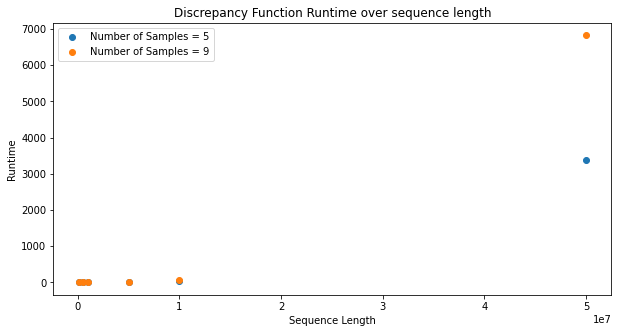

In [20]:
sl_fig, slax = plt.subplots(figsize = (10,5))
for i in range(len(samples)):
    slax.scatter(lengthlist, ltimes[i,:], label=f'Number of Samples = {samples[i]}')
slax.set_xlabel('Sequence Length')
slax.set_ylabel('Runtime')
slax.legend()
slax.set_title('Discrepancy Function Runtime over sequence length')    
plt.savefig('paper/discrepancy_runtime.png')